In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu
import PolyBin3D as pb

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-09-30 21:06:20.599856: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 21:06:20.869415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-30 21:06:20.869467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-30 21:06:20.898308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-30 21:06:20.985277: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## 1 bias param per cosmo

In [4]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
#tag_biasparams = '_biaszen_p4_n100000'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [5]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary = [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

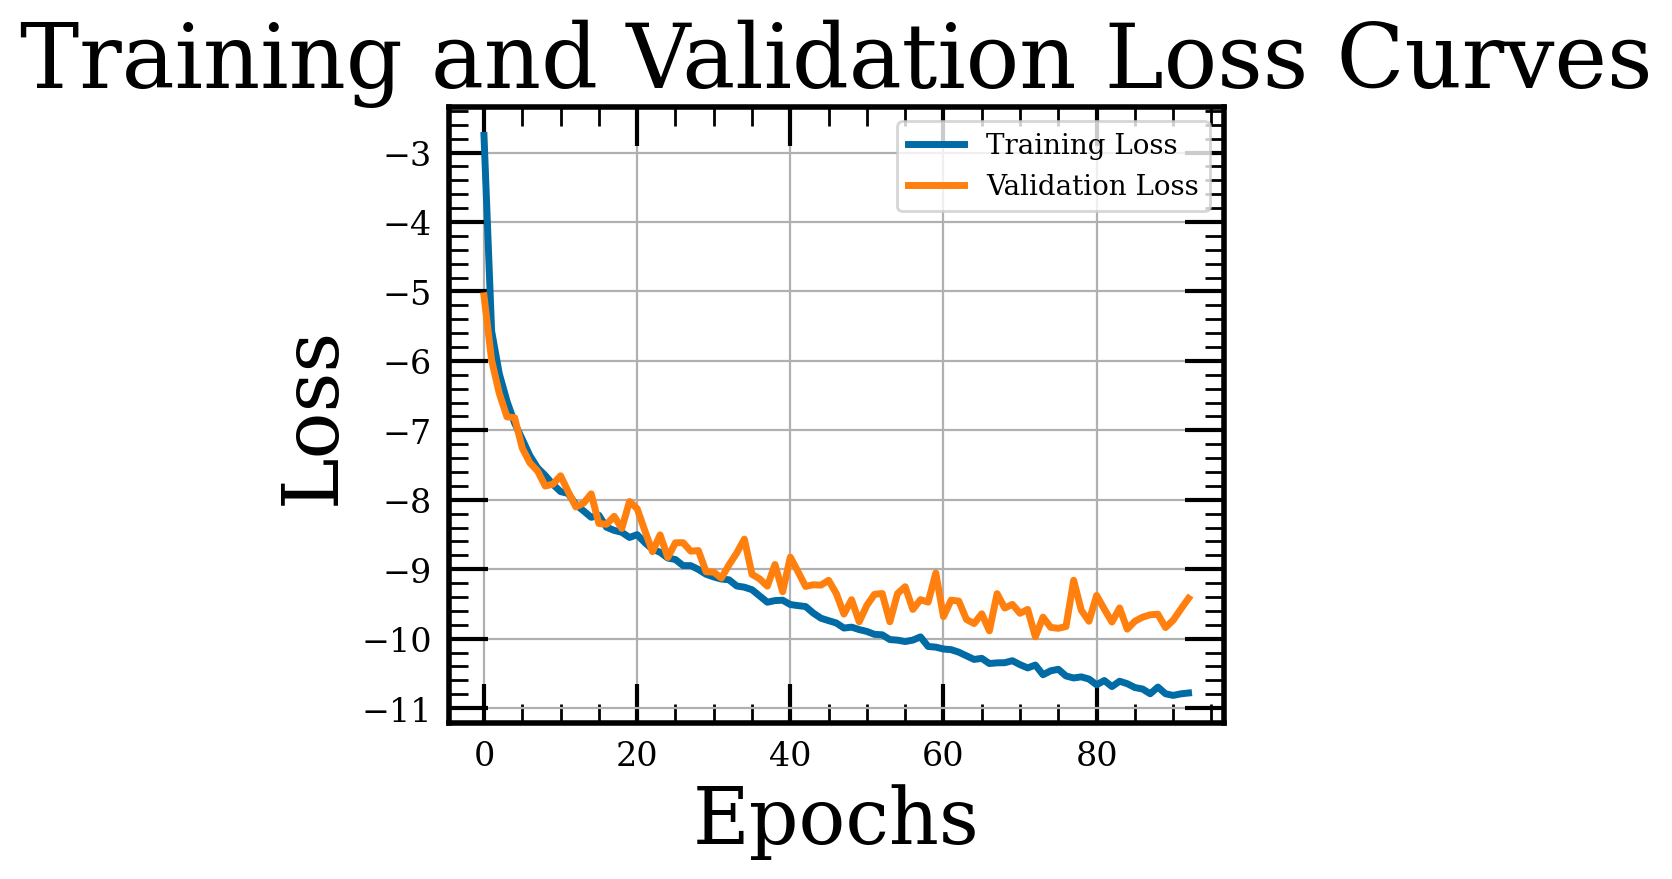

In [6]:
import pickle
dir_sbi = f'../results/results_sbi/sbi{tags_inf[0]}'

fn_inference = f'{dir_sbi}/inference.p'
with open(fn_inference, "rb") as f:
    inference = pickle.load(f)
# Extract training and validation loss
training_loss = inference._summary["training_loss"]
validation_loss = inference._summary["validation_loss"]

# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend(fontsize=10)
#plt.ylim(-10.5, -10)
plt.grid(True)

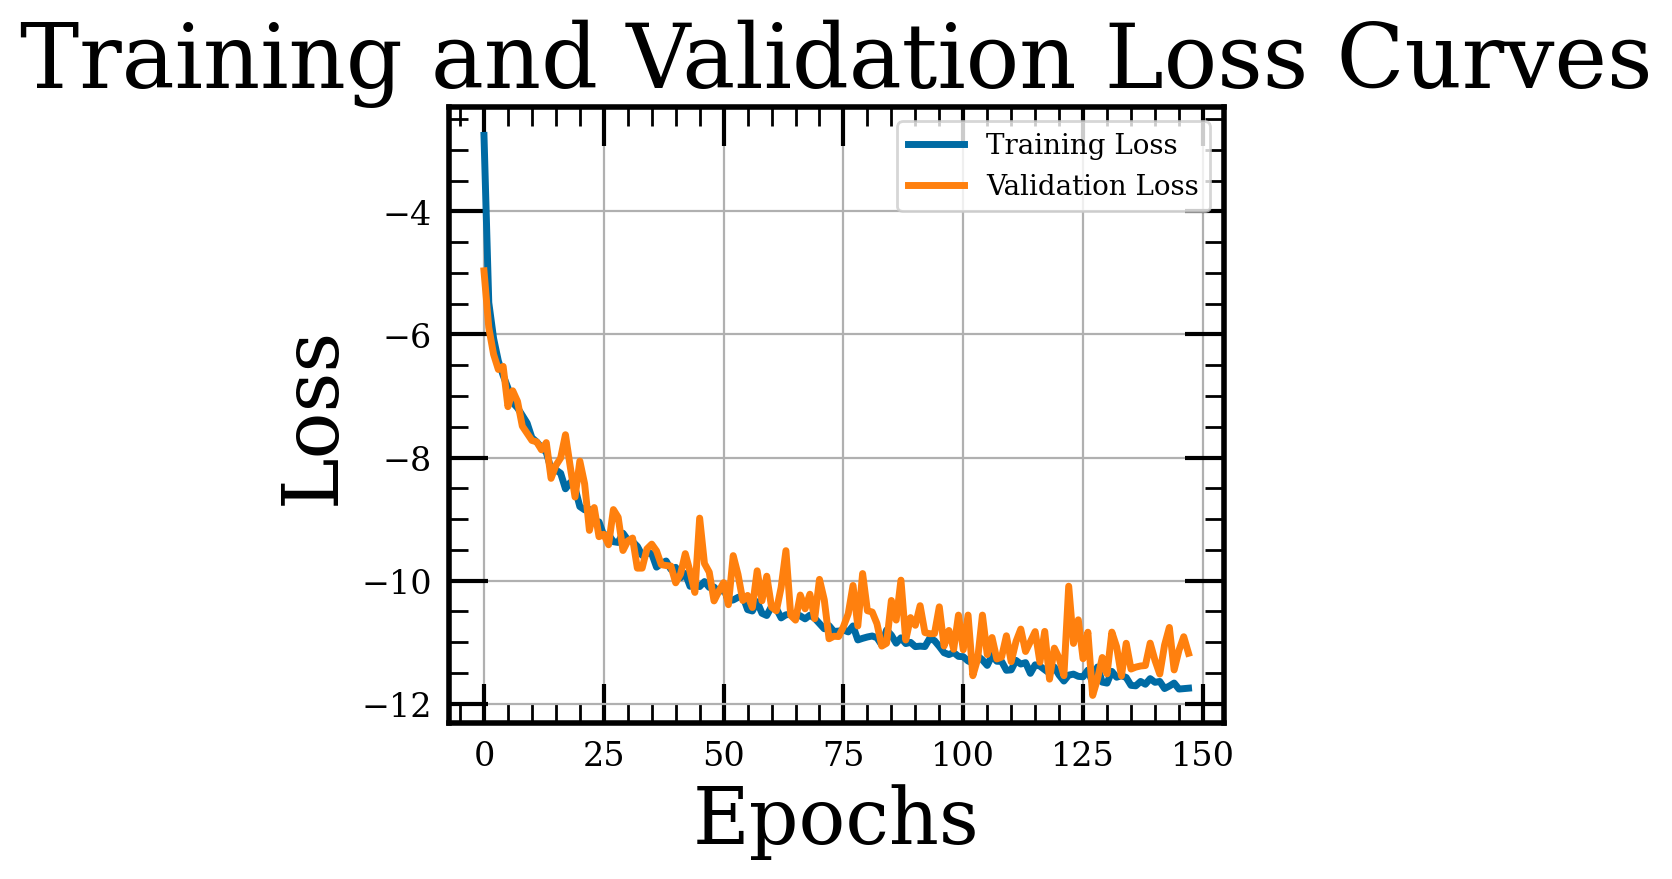

In [7]:
import pickle
dir_sbi = f'../results/results_sbi/sbi{tags_inf[1]}'

fn_inference = f'{dir_sbi}/inference.p'
with open(fn_inference, "rb") as f:
    inference = pickle.load(f)
# Extract training and validation loss
training_loss = inference._summary["training_loss"]
validation_loss = inference._summary["validation_loss"]

# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend(fontsize=10)
#plt.ylim(-10.5, -10)
plt.grid(True)

In [8]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_datagen_test_fixed = ''
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test_fixed.shape)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

tag_Anoise_test None
None
{}
9
(9,)


[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


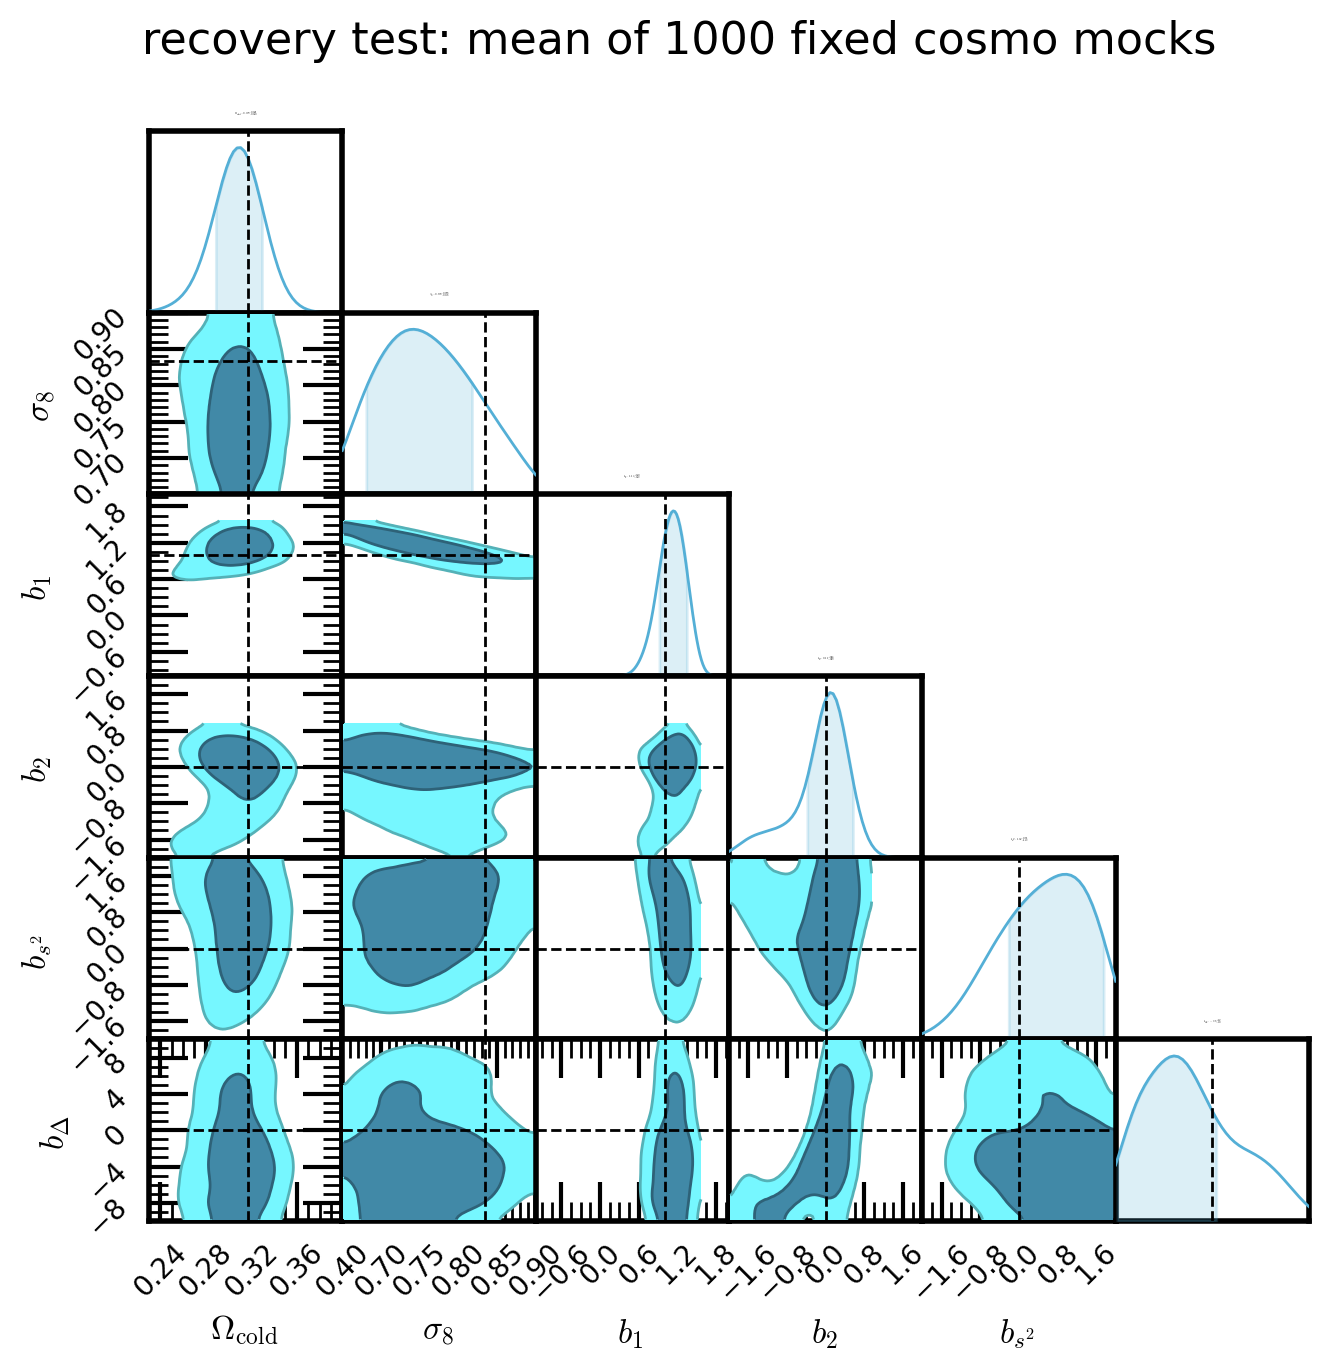

In [9]:
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
title = 'recovery test: mean of 1000 fixed cosmo mocks'
tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test_fixed + '_mean' for tag_stats in tag_stats_arr]


#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_fixed_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]
plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_fixed_show, 
                        inf_methods[:1], tags_inf[:1], tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


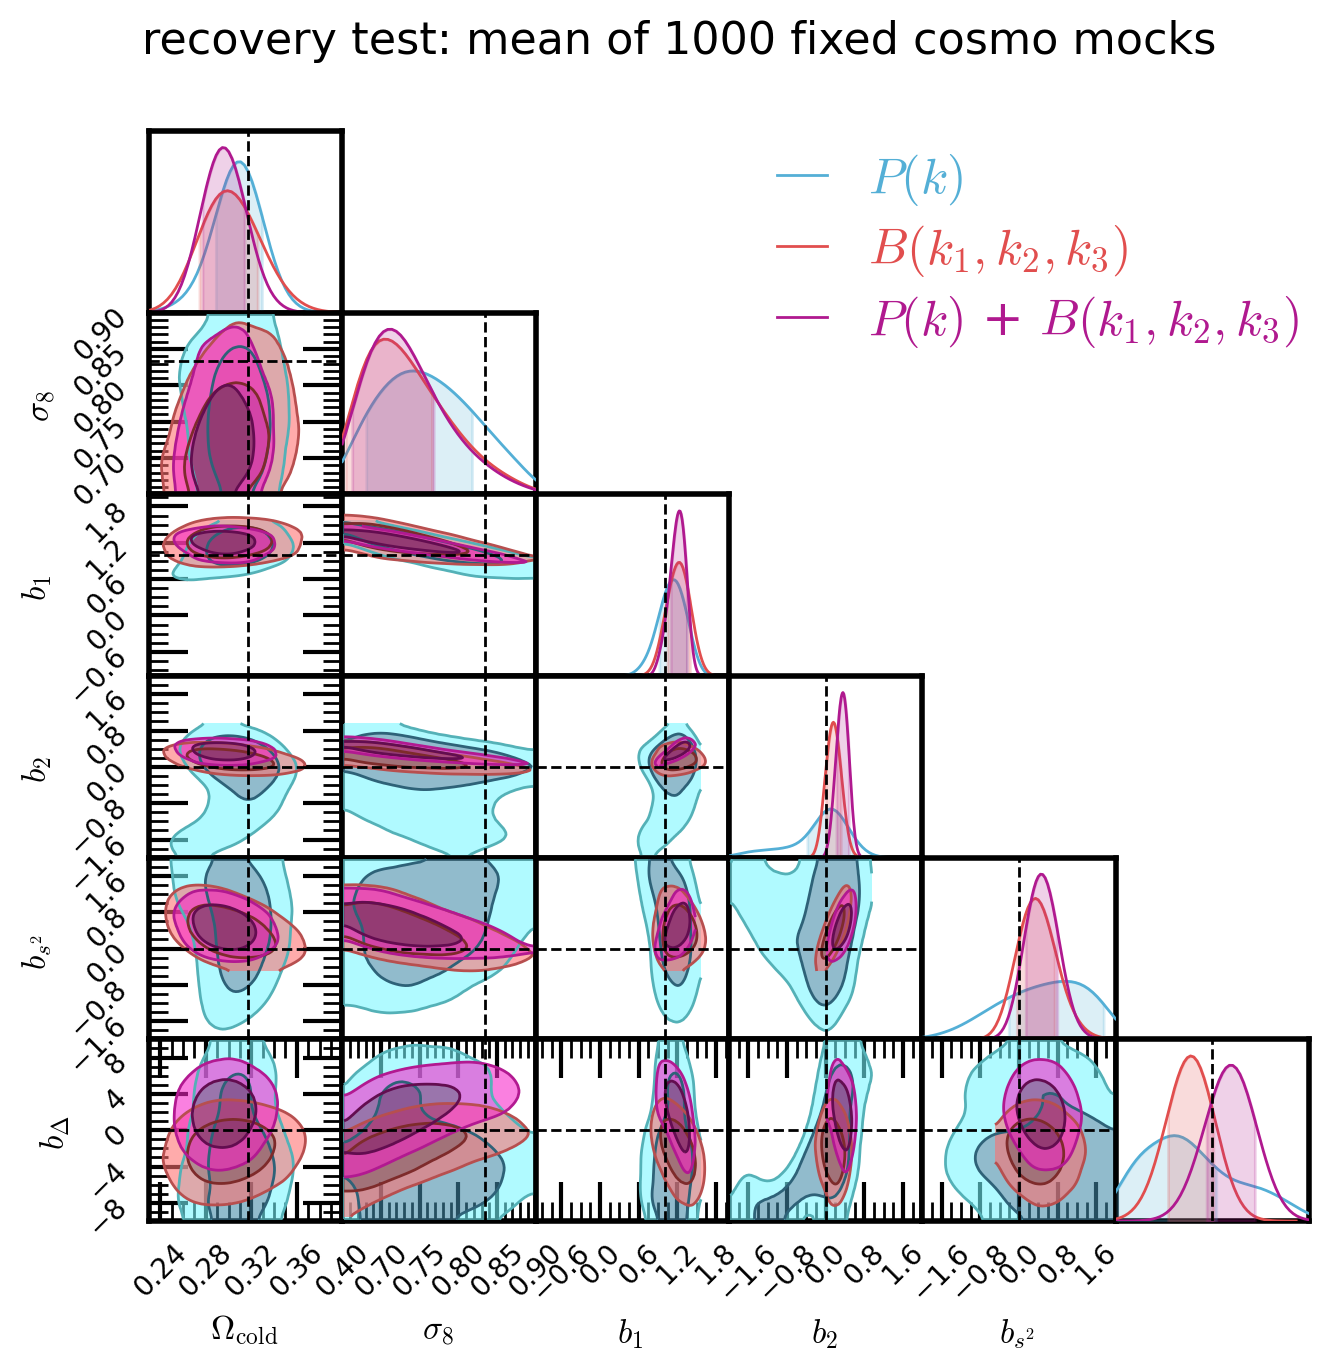

In [10]:
plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_fixed_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

In [11]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i, tag_stats in enumerate(tag_stats_arr)]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000


In [12]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

1000
1000
1000


In [14]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
# plotter.plot_hists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
#                         color_arr=colors, label_arr=labels,
#                         n_bins=12, alpha=0.8, histtype='step',
#                         xlim_auto=False)

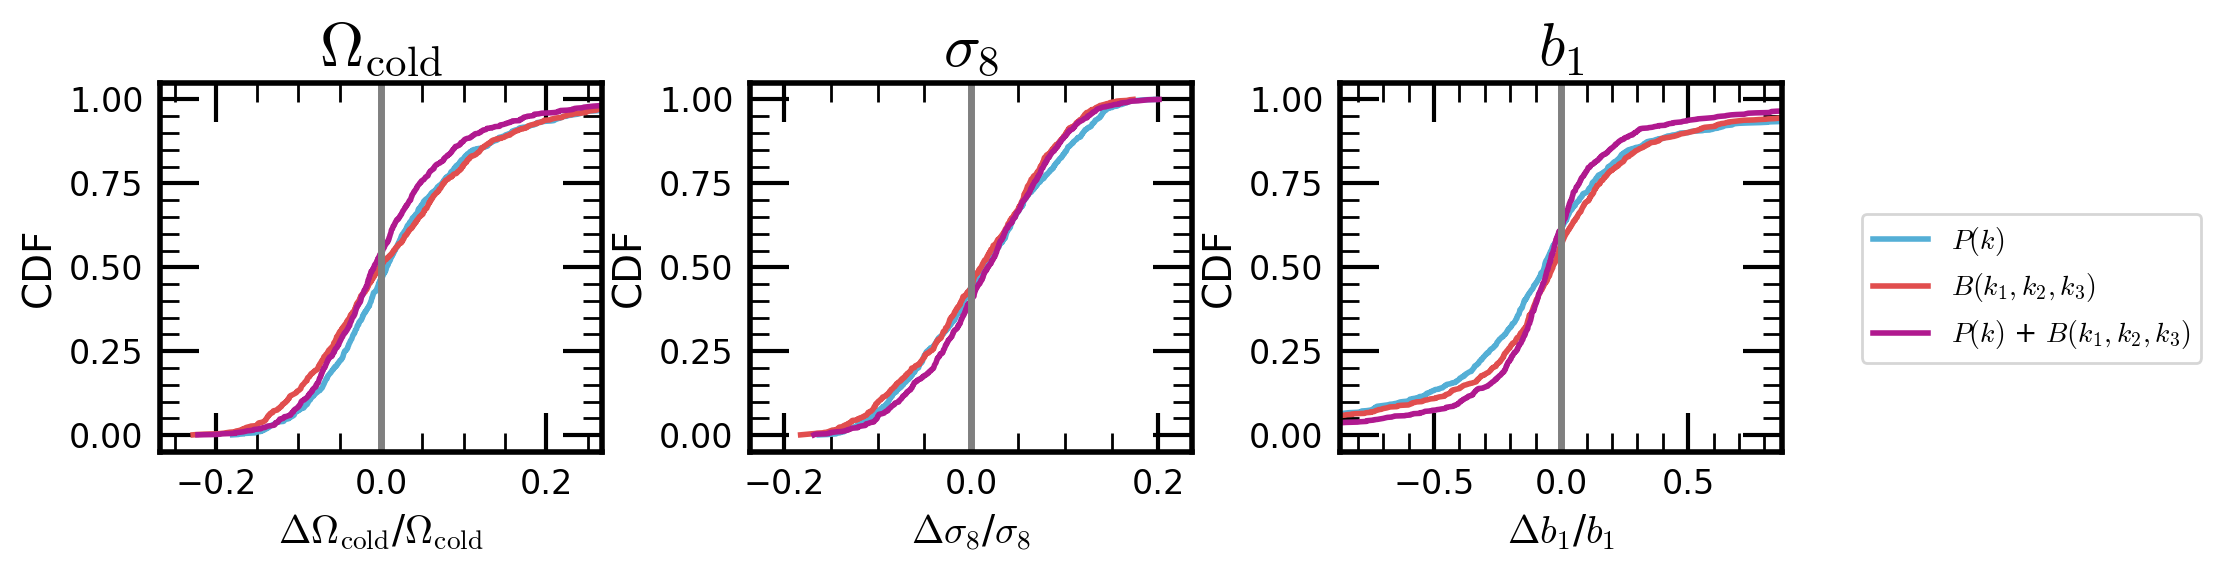

In [15]:

plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=12, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

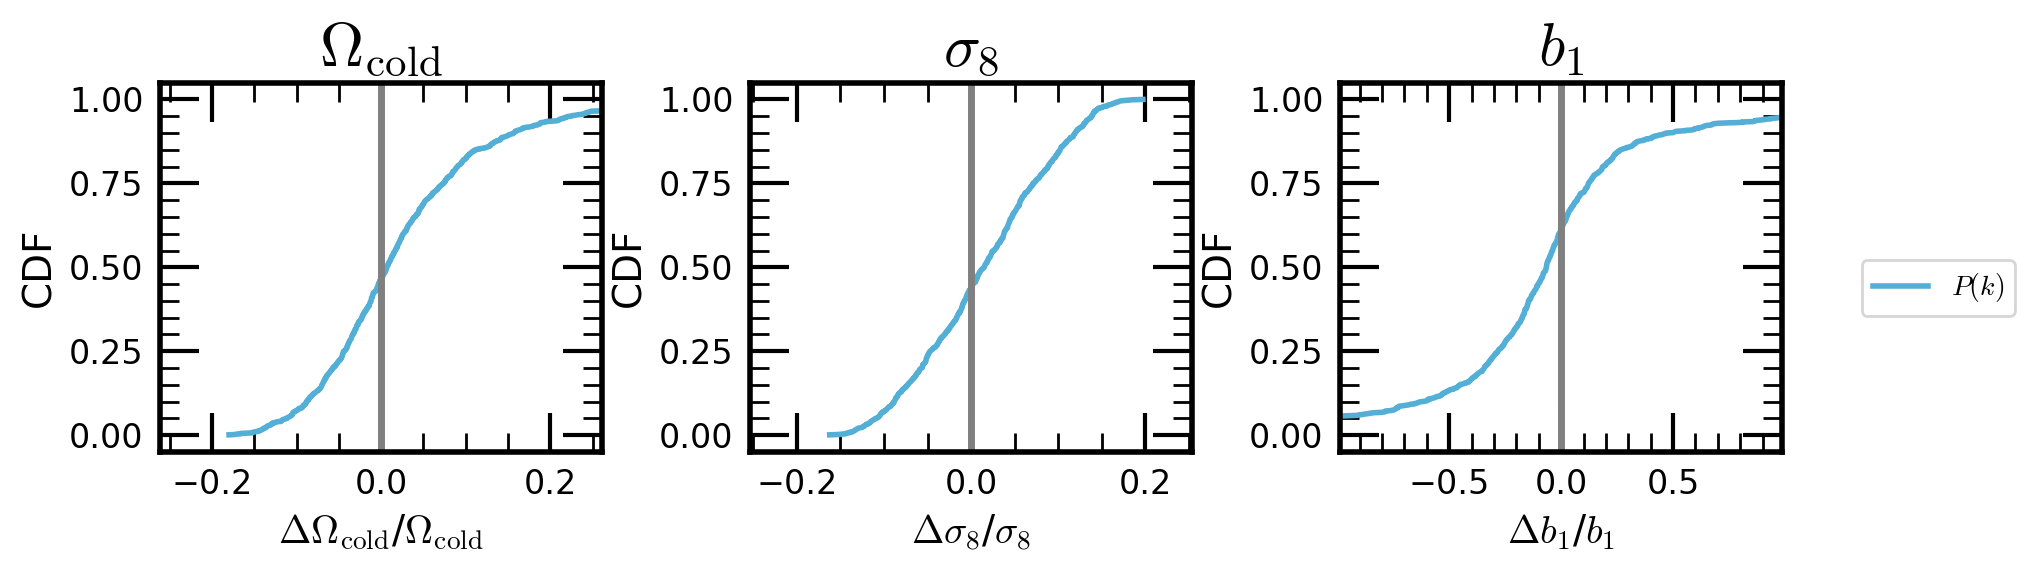

In [16]:
plotter.plot_dists_mean_subplots(theta_pred_arr[:1], theta_true_arr[:1], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=12, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

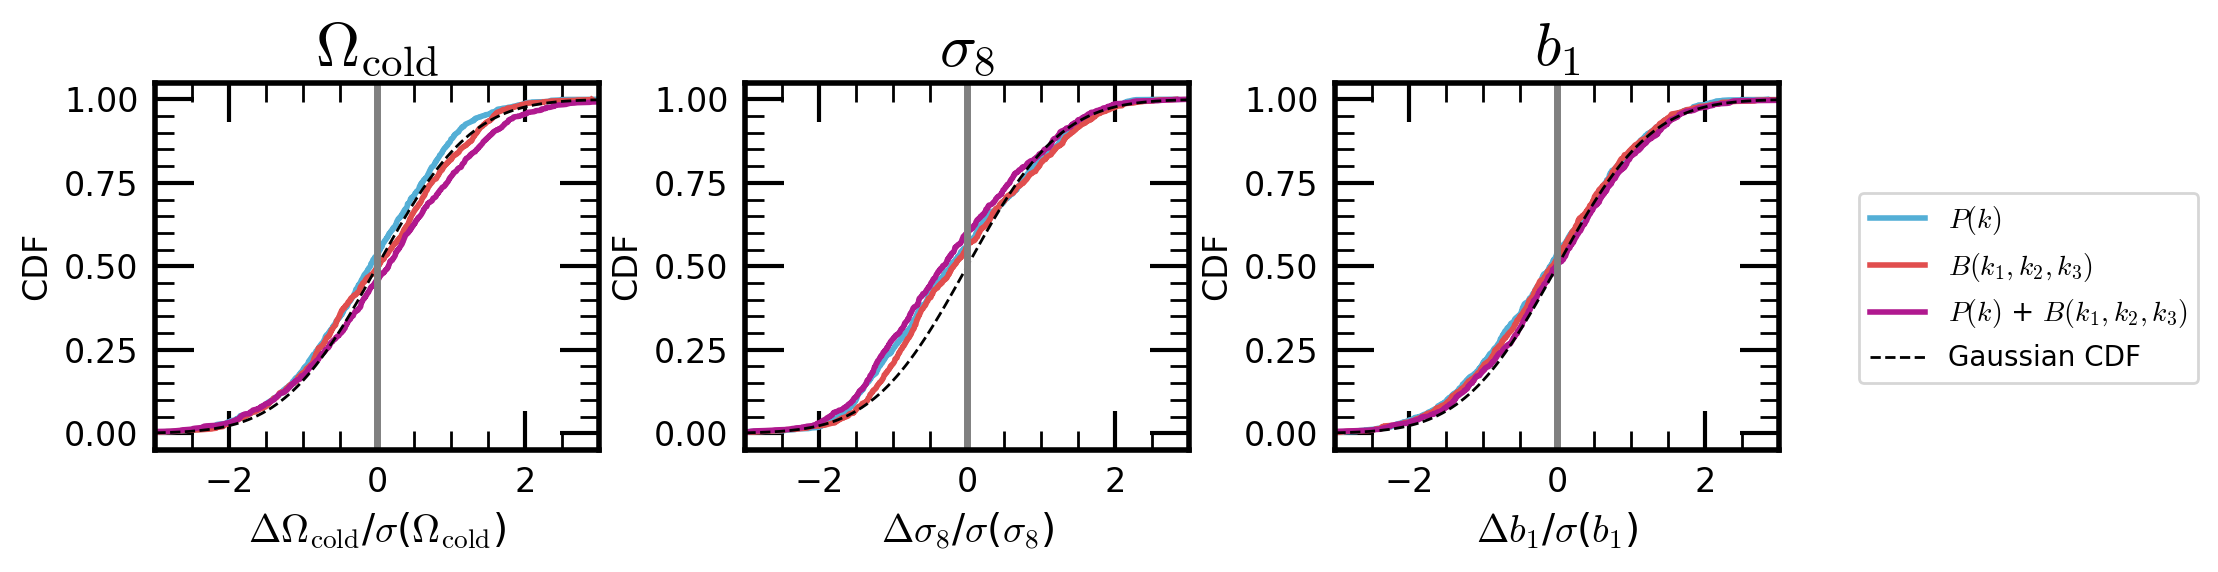

In [17]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

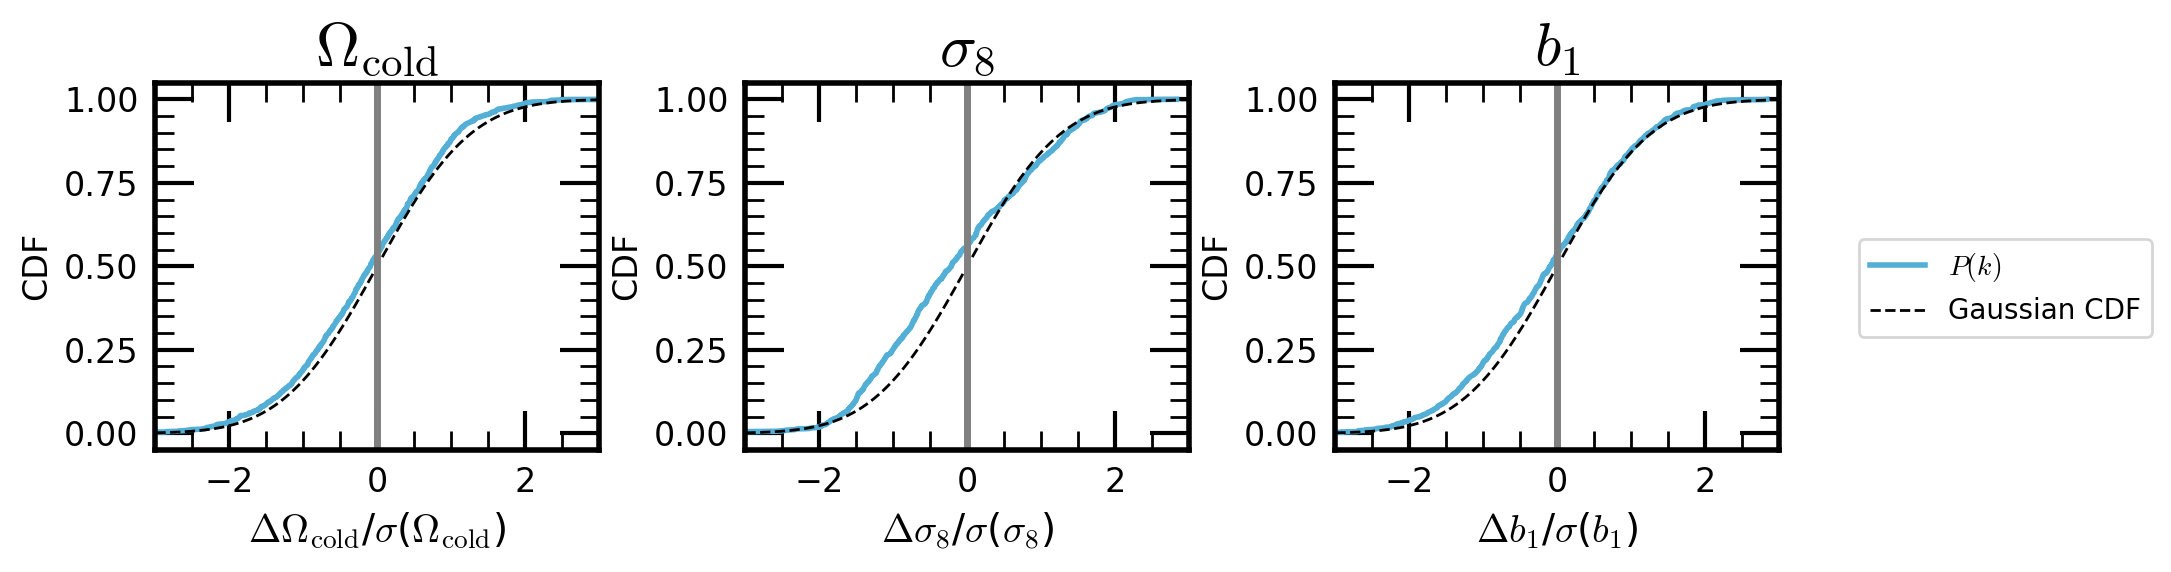

In [18]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr[:1], theta_true_arr[:1], covs_pred_arr[:1], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

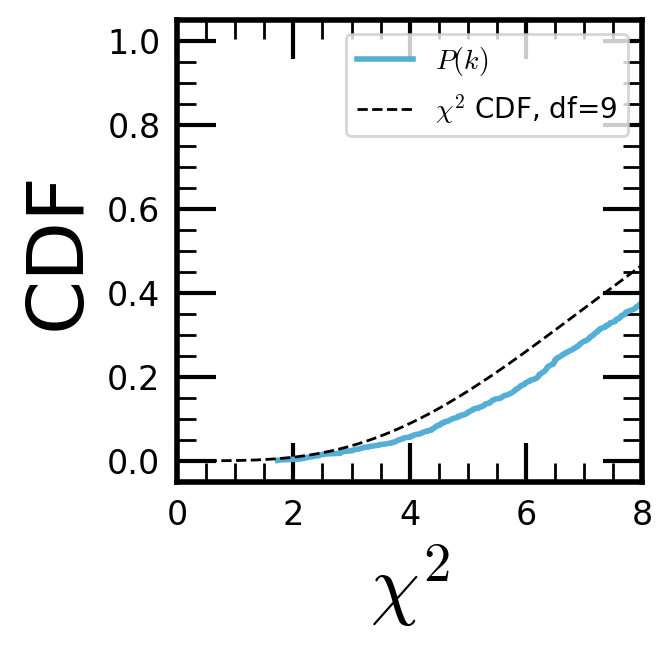

In [19]:
plotter.plot_dists_chi2(chi2s_arr, len(param_names_vary),
                        color_arr=colors, 
                        label_arr=labels,
                        alpha=0.8, histtype='step',
                        #xlim_auto=False,
                        plot_cdf=True)

## p(k), bispec with 20x {b}

In [20]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
#tag_biasparams = '_biaszen_p4_n10000'
#tag_biasparams = '_biaszen_p4_n100000'
tag_biasparams = '_biaszen_p4_n200000'
n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [21]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary = [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

In [22]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_datagen_test_fixed = ''
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary)
print(theta_test_fixed.shape)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
extents = {**dict_bounds_cosmo, **dict_bounds_bias}

tag_Anoise_test None
None
{}
9
(9,)


In [23]:
tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test_fixed + '_mean' for tag_stats in tag_stats_arr]

fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


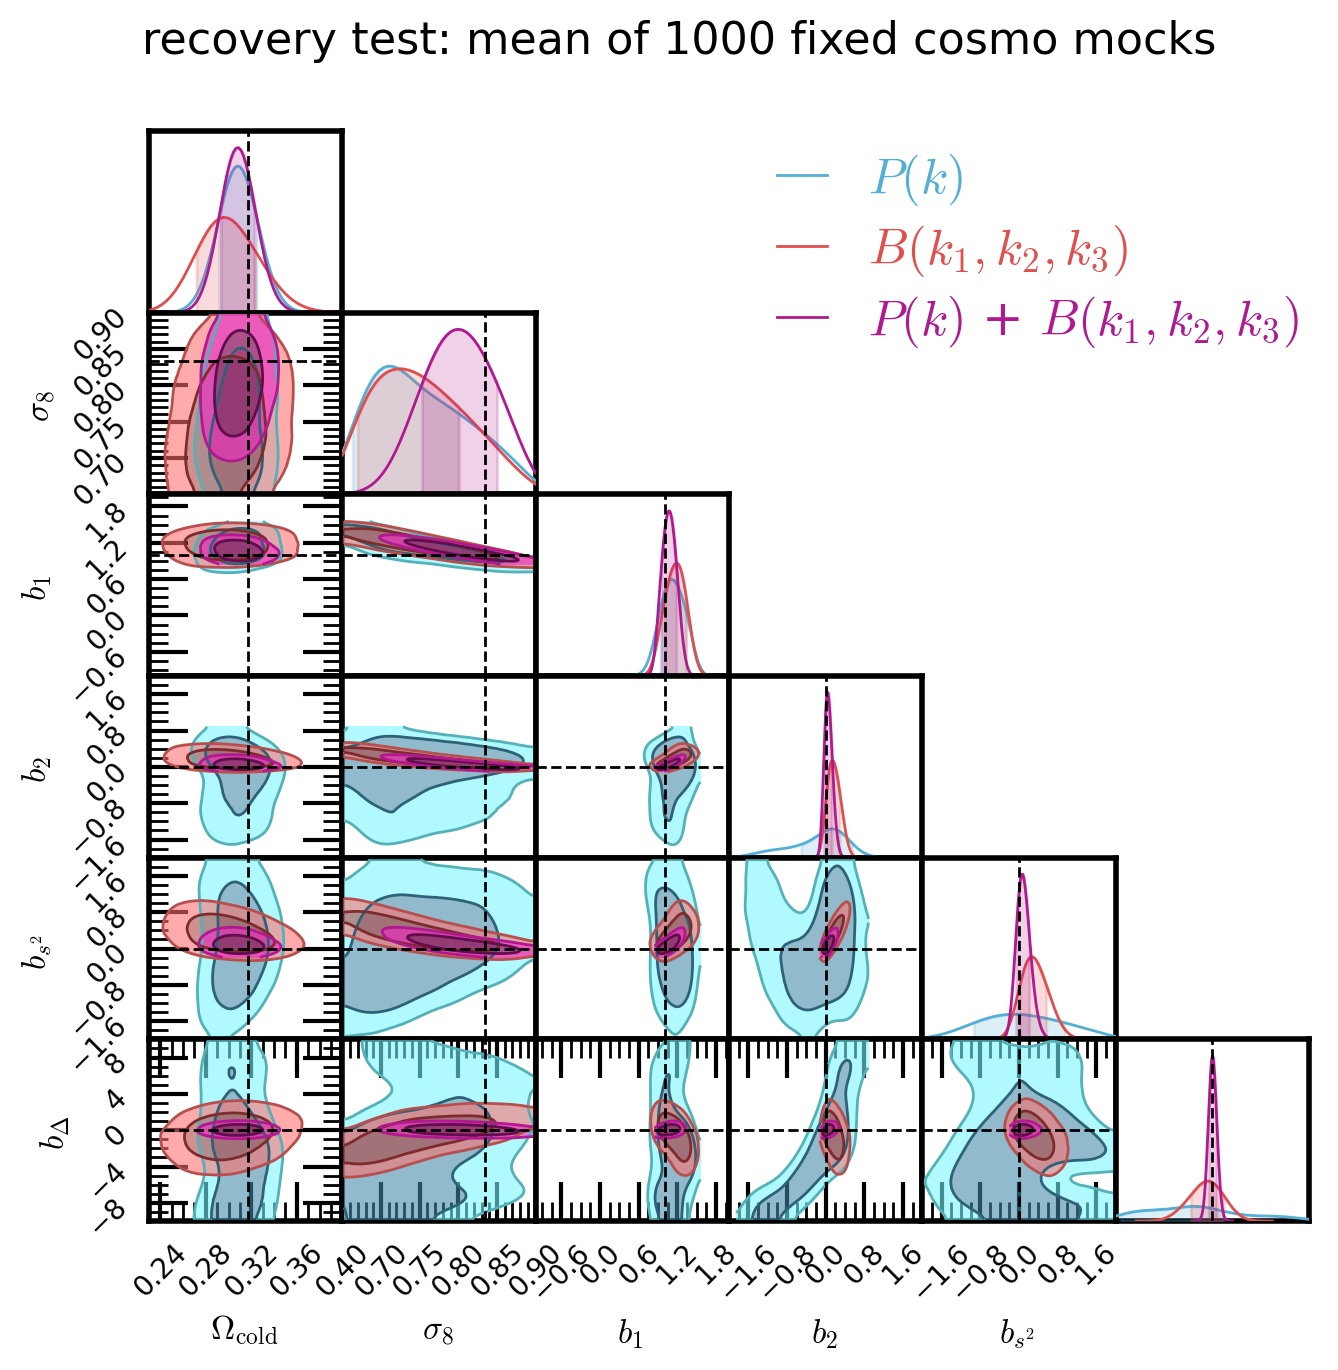

In [24]:
plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_fixed_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

In [ ]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i, tag_stats in enumerate(tag_stats_arr)]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000


In [ ]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

1000


FileNotFoundError: [Errno 2] No such file or directory: '../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy'

In [ ]:

plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=12, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

TypeError: unsupported operand type(s) for /: 'list' and 'list'

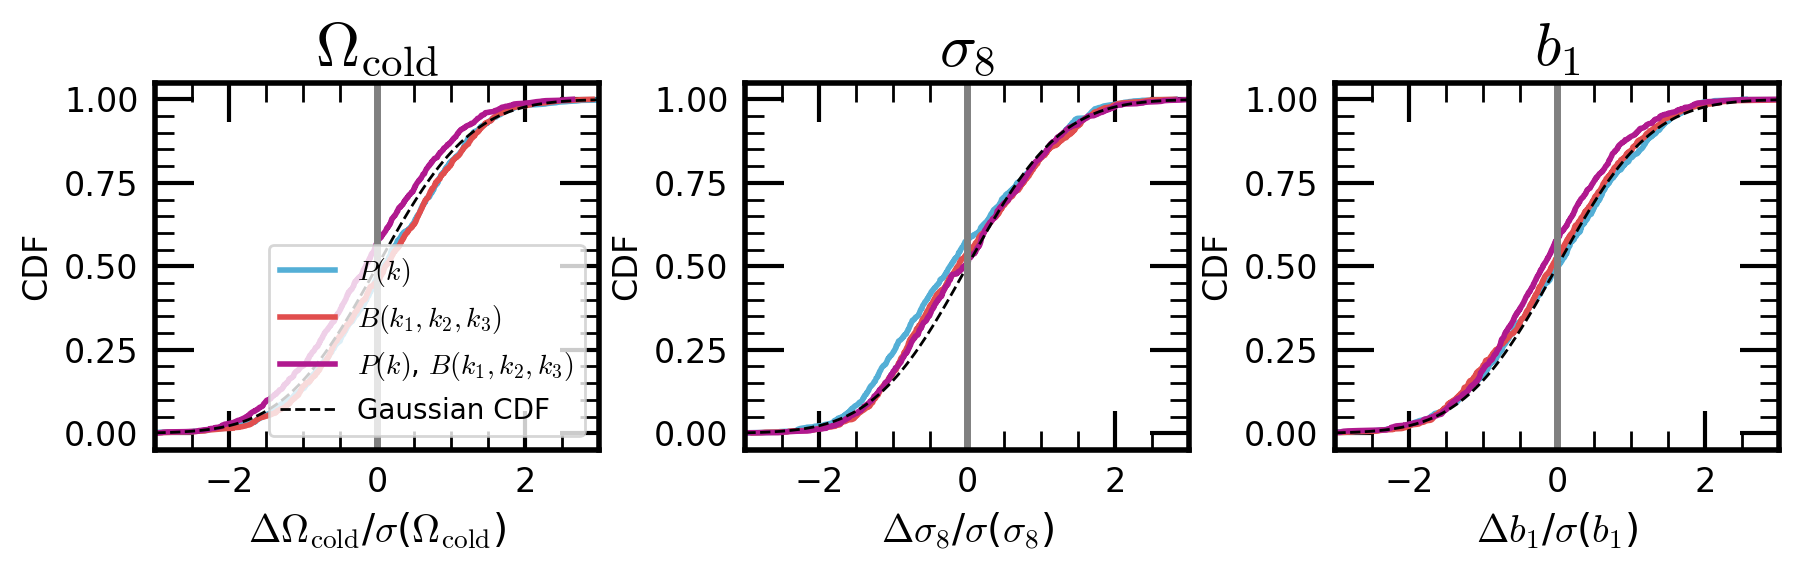

In [ ]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

## bias parameter freedom tests

WARNING these files were moved so these don't exist right now! ideally rerun train/test and replot

In [ ]:
inf_methods = [
               "sbi",
               'sbi',
               'sbi',
              ]
tags_inf = [
            f'_muchisimocksPk_p5_n10000_b1000_p0_n1_ntrain10000_best-sbi-rand10',
            # TODO switch to this best one when done running
            f'_muchisimocksPk_p5_n10000_b1zen_p1_n10000_ntrain10000_best-sbi-rand10',
            #f'_muchisimocksPk_p5_n10000_b1zen_p1_n10000_ntrain10000',
            f'_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10',
            ]
labels = [
                'b=[1,0,0,0] (best)',
                'b1 free (best)',
                'bias free (best)',
                ]
#colors = [ut
# ils.color_dict_methods[meth] for meth in inf_methods]
colors = ['blue', 'purple', 'cyan']

In [ ]:
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
tags_test = ['_'+data_mode + 'Pk' + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test + '_mean' for tag_inf in tags_inf]
param_names_vary = cosmo_param_names_vary
plotter.plot_contours_inf(param_names_vary, idx_obs, theta_test_fixed, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocksPk_p5_n10000_b1000_p0_n1_ntrain10000_best-sbi-rand10/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


FileNotFoundError: [Errno 2] No such file or directory: '../results/results_sbi/sbi_muchisimocksPk_p5_n10000_b1000_p0_n1_ntrain10000_best-sbi-rand10/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy'

In [ ]:
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_biasparams_x10 = '_biaszen_p4_n100000'

inf_methods = [
               'sbi',
               'sbi',
              ]
tags_inf = [
            f'_muchisimocksPk{tag_params}{tag_biasparams}_ntrain10000_best-sbi-rand10',
            # TODO switch to this best one when done running
            f'_muchisimocksPk{tag_params}{tag_biasparams_x10}_ntrain10000',
            ]
labels = [
                '1 bias param set per cosmo',
                '10 bias param sets per cosmo',
                ]
color_pk10 = "#2e52be"
colors = [
          color_pk,
          color_pk10]

[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
['omega_cold', 'sigma8_cold', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)
fn_samples = ../results/results_sbi/sbi_muchisimocksPk_p5_n10000_biaszen_p4_n100000_ntrain10000/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)


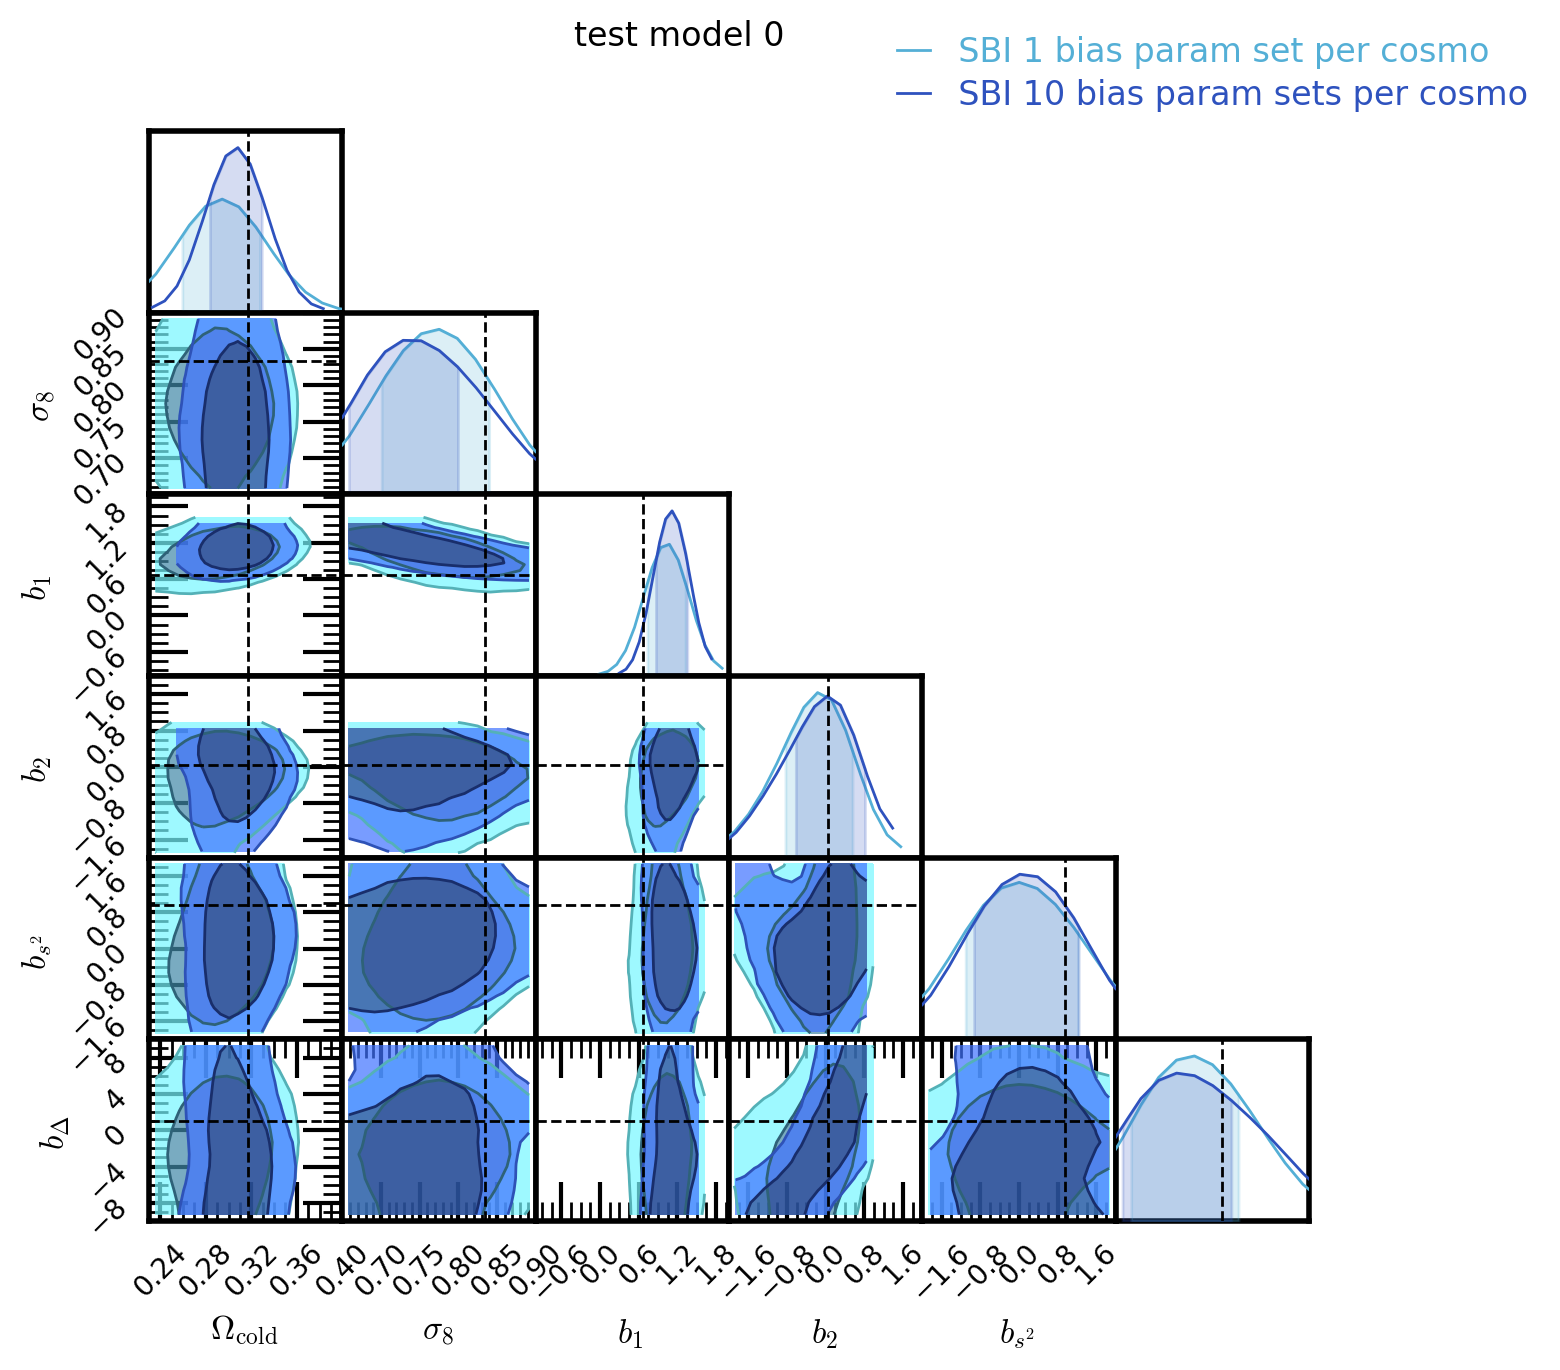

In [ ]:
print(theta_test_fixed)
print(param_names_vary)
idx_obs = 0
tag_data_test_fixed = '_'+data_mode + 'Pk' + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test
tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
param_names_vary = param_names_contour
title = None
plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_fixed, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

In [ ]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = [
                        '_biaszen_p4_n1000',
                        '_biaszen_p4_n1000',
                        ]
tag_datagen_test = ''
tags_data_test = ['_'+data_mode + 'Pk' + tag_params_test + tag_biasparams_test + tag_datagen_test for tag_biasparams_test in tags_biasparams_test]
print(tag_data_test)
print(theta_test.shape)

_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000
(1000, 9)


In [ ]:
labels = [
                '1x bias param',
                '10x bias params',
                ]

In [ ]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):
    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

(10000, 1000, 9)
(10000, 1000, 9)


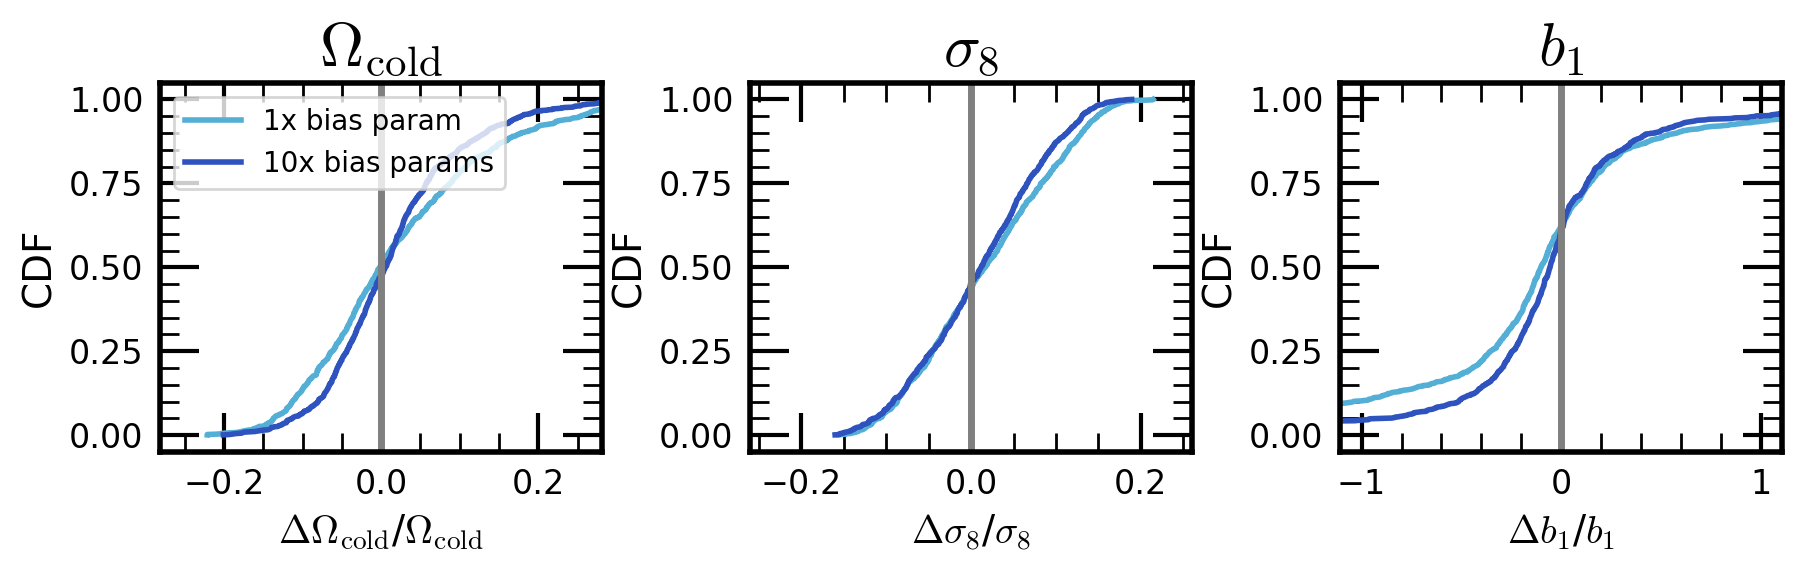

In [ ]:
param_names_plot = ['omega_cold', 'sigma8_cold', 'b1']

plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_plot, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=12, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)

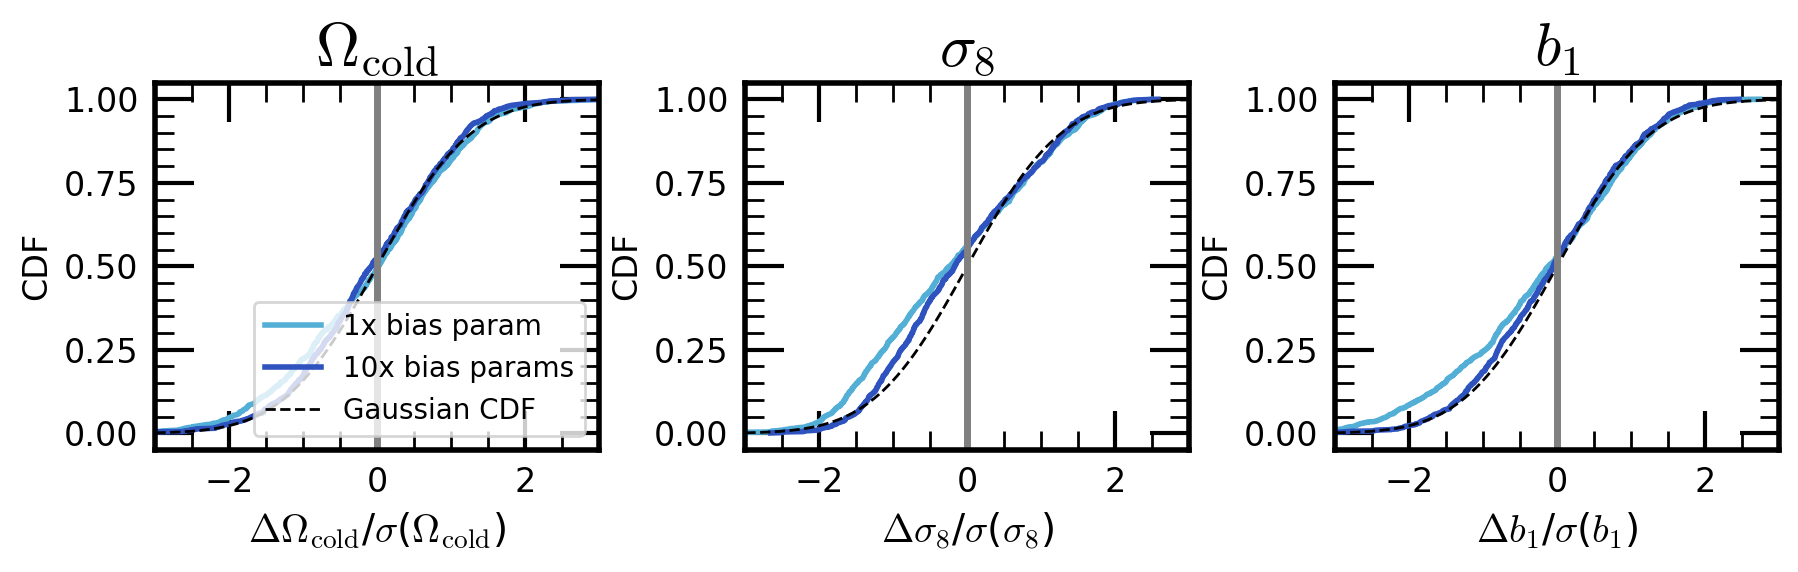

In [ ]:
sigmas_from_truth_arr, chi2s_arr = plotter.plot_dists_cov_subplots(theta_pred_arr, theta_true_arr, covs_pred_arr, param_names_show, param_names_plot=param_names_plot, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=True)